# Transformer Architecture — Definition, Derivation, Computation & Visualizations

**Goals of this notebook**

1. Give a concise definition and derivation of core Transformer components.
2. Show step-by-step computation for self-attention and multi-head attention with printed intermediate values.
3. Provide visualizations (attention heatmap, 2D PCA, 3D PCA) so the mechanism is obvious.
4. Provide a code example of a minimal Transformer encoder block and how to apply it to a toy sequence.
5. Explain how the same components are used for images (flatten → tokens) such as MNIST.

All math is enclosed in `$...$`.


## Definitions & Core Formulas

**Self-Attention (Scaled Dot-Product)**

Given queries $Q \in \mathbb{R}^{n\times d}$, keys $K\in\mathbb{R}^{m\times d}$, and values $V\in\mathbb{R}^{m\times d_v}$:

1. Raw compatibility scores:
   $$S = QK^\top \quad (S_{ij} = q_i^\top k_j).$$

2. Scale to control variance:
   $$\tilde S = \frac{S}{\sqrt{d}}.$$

3. Softmax across keys for each query:
   $$A = \text{softmax}(\tilde S) \qquad (A_{i,:} = \text{softmax}(\tilde S_{i,:})).$$

4. Weighted sum:
   $$\text{Attention}(Q,K,V) = A\,V.$$

**Multi-Head Attention**

Split the model dimension $d$ into $h$ heads, each with dimension $d_h = d/h$. Perform attention in each head, then concatenate:

$$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1,\dots,\text{head}_h)W_o$$

where

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V).$$

**Transformer Layer (Encoder)**

Each encoder block computes:

1. Multi-head attention with residual & layer norm:

$$X' = \text{LayerNorm}(X + \text{MultiHead}(X,X,X)).$$

2. Position-wise feedforward:

$$\text{FFN}(X') = W_2 \,\text{GELU}(W_1 X' + b_1) + b_2.$$

3. Residual & normalization:

$$\text{Output} = \text{LayerNorm}(X' + \text{FFN}(X')).$$

**Positional Encoding**

Since self-attention is permutation-invariant, add positional encodings $p_t$ to token embeddings $e_t$:

$$\tilde e_t = e_t + p_t.$$

A common fixed form:

$$p_{t,2k} = \sin\left(\frac{t}{10000^{2k/d}}\right), \quad p_{t,2k+1} = \cos\left(\frac{t}{10000^{2k/d}}\right).$$


In [1]:
# Python cell: imports & utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


Positional Encoding shape: (8, 16)
First 3 positions (rows):
 [[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00]
 [ 8.4147096e-01  5.4030228e-01  3.1098360e-01  9.5041525e-01
   9.9833414e-02  9.9500418e-01  3.1617507e-02  9.9950004e-01
   9.9998331e-03  9.9994999e-01  3.1622723e-03  9.9999499e-01
   9.9999981e-04  9.9999952e-01  3.1622776e-04  9.9999994e-01]
 [ 9.0929741e-01 -4.1614684e-01  5.9112710e-01  8.0657840e-01
   1.9866933e-01  9.8006660e-01  6.3203394e-02  9.9800068e-01
   1.9998666e-02  9.9980003e-01  6.3245133e-03  9.9997997e-01
   1.9999987e-03  9.9999797e-01  6.3245551e-04  9.9999982e-01]]


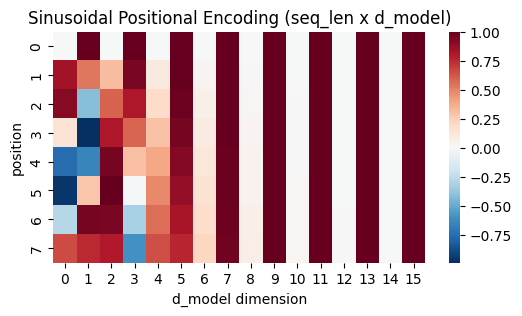

In [2]:
# Python cell: positional encoding implementation and demonstration
def sinusoidal_positional_encoding(seq_len, d_model):
    """Return (seq_len, d_model) numpy array of positional encodings."""
    pe = np.zeros((seq_len, d_model), dtype=np.float32)
    position = np.arange(0, seq_len)[:, np.newaxis]  # (seq_len,1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

# Demonstrate
seq_len = 8
d_model = 16
pe = sinusoidal_positional_encoding(seq_len, d_model)
print("Positional Encoding shape:", pe.shape)
print("First 3 positions (rows):\n", pe[:3])

# Visualization of positional encoding (heatmap)
plt.figure(figsize=(6,3))
sns.heatmap(pe, cmap='RdBu_r')
plt.title("Sinusoidal Positional Encoding (seq_len x d_model)")
plt.xlabel("d_model dimension")
plt.ylabel("position")
plt.show()


In [3]:
# Python cell: scaled dot-product attention with verbose prints
def scaled_dot_product_attention_torch(Q, K, V, mask=None, verbose=True):
    """
    Q: (n_q, d), K: (n_k, d), V: (n_k, d_v)
    returns: out (n_q, d_v), attention weights (n_q, n_k)
    """
    # Convert to torch tensors if needed
    if not isinstance(Q, torch.Tensor):
        Q = torch.tensor(Q, dtype=torch.float32)
    if not isinstance(K, torch.Tensor):
        K = torch.tensor(K, dtype=torch.float32)
    if not isinstance(V, torch.Tensor):
        V = torch.tensor(V, dtype=torch.float32)

    d = Q.shape[-1]
    # 1) raw scores
    S = Q @ K.T  # (n_q, n_k)
    if verbose:
        print("Raw scores S shape:", S.shape)
        print(S.numpy())

    # 2) scale
    S_scaled = S / np.sqrt(d)
    if verbose:
        print("\nScaled scores (S / sqrt(d)):")
        print(S_scaled.numpy())

    # 3) mask (optional)
    if mask is not None:
        S_scaled = S_scaled.masked_fill(mask == 0, float('-1e9'))
        if verbose:
            print("\nAfter mask applied (masked positions set to -inf approx):")
            print(S_scaled.numpy())

    # 4) softmax
    A = F.softmax(S_scaled, dim=-1)
    if verbose:
        print("\nAttention weights A (rows sum to 1):")
        print(A.numpy())
        print("Row sums:", A.sum(dim=-1).numpy())

    # 5) output
    out = A @ V
    if verbose:
        print("\nAttention output (A @ V) shape:", out.shape)
        print(out.numpy())

    return out, A

# Toy demonstration
d = 8
n_q = 3
n_k = 5
Q = np.random.randn(n_q, d).astype(np.float32) * 0.7
K = np.random.randn(n_k, d).astype(np.float32) * 0.7
V = np.random.randn(n_k, d).astype(np.float32) * 0.7

print("=== Scaled Dot-Product Attention Demo ===")
out, A = scaled_dot_product_attention_torch(Q, K, V, verbose=True)


=== Scaled Dot-Product Attention Demo ===
Raw scores S shape: torch.Size([3, 5])
[[ 2.2362995  -0.7587862  -0.7585566  -1.3883214  -1.2794265 ]
 [ 0.21715748  0.13004118  0.67548877  0.05435501 -0.977072  ]
 [ 0.37449723 -1.7777127  -2.0191941  -1.3662653   1.0822163 ]]

Scaled scores (S / sqrt(d)):
[[ 0.79065126 -0.26827145 -0.26819026 -0.49084574 -0.45234558]
 [ 0.07677677  0.0459765   0.23882134  0.0192174  -0.34544712]
 [ 0.13240477 -0.6285164  -0.71389294 -0.48304772  0.38262123]]

Attention weights A (rows sum to 1):
[[0.44251192 0.15347607 0.15348855 0.12285078 0.12767278]
 [0.21073774 0.2043459  0.24780917 0.1989503  0.13815697]
 [0.26874962 0.12556945 0.11529366 0.1452313  0.34515604]]
Row sums: [1.0000001 1.0000001 1.0000001]

Attention output (A @ V) shape: torch.Size([3, 8])
[[-0.0389588   0.08995331 -0.43504012  0.04577321 -0.0284854   0.12113702
   0.23612268  0.17405412]
 [-0.16106193  0.23992151 -0.14602727 -0.08705498  0.21088442  0.25940624
   0.19422737  0.18800148]


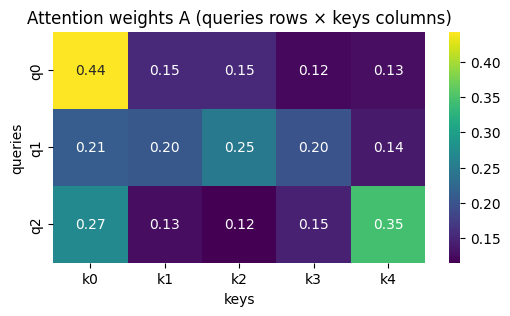

In [4]:
# Python cell: plot attention heatmap from previous cell
A_np = A.numpy()
plt.figure(figsize=(6,3))
sns.heatmap(A_np, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=[f"k{j}" for j in range(A_np.shape[1])],
            yticklabels=[f"q{i}" for i in range(A_np.shape[0])])
plt.title("Attention weights A (queries rows × keys columns)")
plt.xlabel("keys")
plt.ylabel("queries")
plt.show()


In [6]:
class MiniMultiHead(nn.Module):
    def __init__(self, d_model=16, num_heads=4):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias=False)

    def forward(self, X, verbose=True):
        # X: (n, d_model)
        n = X.shape[0]
        Q = self.Wq(X)  # (n, d_model)
        K = self.Wk(X)
        V = self.Wv(X)

        # Split into heads: shape -> (num_heads, n, d_k)
        Qh = Q.view(n, self.num_heads, self.d_k).permute(1, 0, 2)
        Kh = K.view(n, self.num_heads, self.d_k).permute(1, 0, 2)
        Vh = V.view(n, self.num_heads, self.d_k).permute(1, 0, 2)

        heads_out = []
        heads_A = []
        for h in range(self.num_heads):
            if verbose:
                print(f"\n--- Head {h} ---")
                print("Qh shape:", Qh[h].shape, "Kh shape:", Kh[h].shape, "Vh shape:", Vh[h].shape)

            out_h, Ah = scaled_dot_product_attention_torch(
                Qh[h].detach().cpu().numpy(),   # FIX
                Kh[h].detach().cpu().numpy(),   # FIX
                Vh[h].detach().cpu().numpy(),   # FIX
                mask=None, verbose=False
            )

            heads_out.append(torch.tensor(out_h))
            heads_A.append(Ah)

        # Concatenate heads outputs
        heads_out_cat = torch.cat(heads_out, dim=-1).to(X.device)  # (n, d_model)
        final = self.Wo(heads_out_cat.float())
        if verbose:
            print("\nConcatenated heads output shape:", heads_out_cat.shape)
            print("Final MHA output shape:", final.shape)
        return final, heads_A


# Demo
n_tokens = 6
d_model = 16
mini_mha = MiniMultiHead(d_model, num_heads=4).to(device)
X_demo = torch.randn(n_tokens, d_model, device=device)
print("\nRunning MiniMultiHead on toy input...")
out_mha, heads_attn = mini_mha(X_demo, verbose=True)



Running MiniMultiHead on toy input...

--- Head 0 ---
Qh shape: torch.Size([6, 4]) Kh shape: torch.Size([6, 4]) Vh shape: torch.Size([6, 4])

--- Head 1 ---
Qh shape: torch.Size([6, 4]) Kh shape: torch.Size([6, 4]) Vh shape: torch.Size([6, 4])

--- Head 2 ---
Qh shape: torch.Size([6, 4]) Kh shape: torch.Size([6, 4]) Vh shape: torch.Size([6, 4])

--- Head 3 ---
Qh shape: torch.Size([6, 4]) Kh shape: torch.Size([6, 4]) Vh shape: torch.Size([6, 4])

Concatenated heads output shape: torch.Size([6, 16])
Final MHA output shape: torch.Size([6, 16])


/tmp/ipython-input-4252899302.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heads_out.append(torch.tensor(out_h))


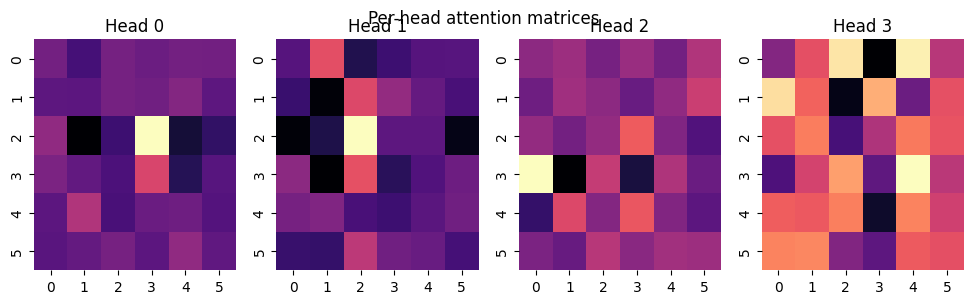

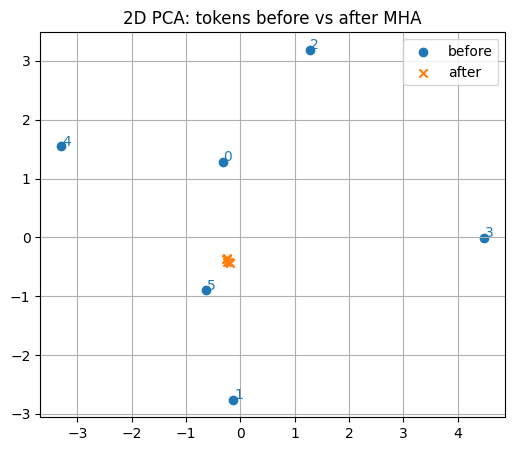

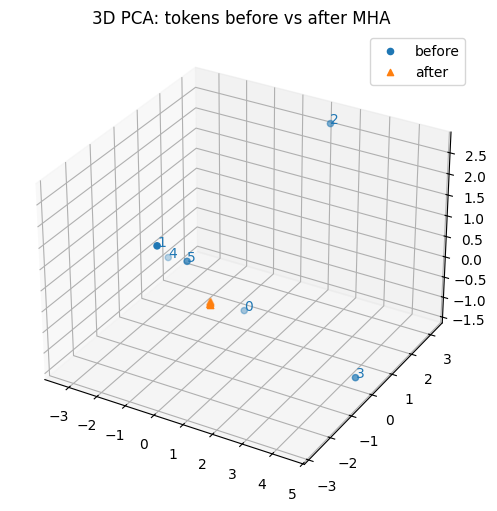

In [7]:
# Python cell: heatmaps for each head + PCA 2D and 3D on token embeddings before/after MHA
# Heatmaps for heads
num_heads = len(heads_attn)
fig, axes = plt.subplots(1, num_heads, figsize=(3*num_heads,3))
for i in range(num_heads):
    sns.heatmap(heads_attn[i], ax=axes[i], cmap='magma', cbar=False)
    axes[i].set_title(f'Head {i}')
plt.suptitle("Per-head attention matrices")
plt.show()

# PCA 2D of token embeddings (before and after MHA)
tokens_before = X_demo.cpu().numpy()
tokens_after = out_mha.detach().cpu().numpy()

pca2 = PCA(n_components=2)
all_tokens = np.vstack([tokens_before, tokens_after])
proj = pca2.fit_transform(all_tokens)
before2 = proj[:n_tokens]
after2 = proj[n_tokens:]

plt.figure(figsize=(6,5))
plt.scatter(before2[:,0], before2[:,1], label='before', c='C0')
plt.scatter(after2[:,0], after2[:,1], label='after', c='C1', marker='x')
for i in range(n_tokens):
    plt.text(before2[i,0]+0.01, before2[i,1]+0.01, str(i), color='C0')
plt.legend(); plt.title("2D PCA: tokens before vs after MHA"); plt.grid(); plt.show()

# PCA 3D
pca3 = PCA(n_components=3)
proj3 = pca3.fit_transform(all_tokens)
before3 = proj3[:n_tokens]
after3 = proj3[n_tokens:]

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(before3[:,0], before3[:,1], before3[:,2], c='C0', label='before')
ax.scatter(after3[:,0], after3[:,1], after3[:,2], c='C1', label='after', marker='^')
for i in range(n_tokens):
    ax.text(before3[i,0], before3[i,1], before3[i,2], str(i), color='C0')
ax.set_title("3D PCA: tokens before vs after MHA")
ax.legend()
plt.show()


In [8]:
# Python cell: minimal Transformer encoder block implementing residual, norm, FFN
class SimpleTransformerBlock(nn.Module):
    def __init__(self, d_model=16, nhead=4, dim_ff=64):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Linear(dim_ff, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, attn_mask=None):
        # x: (batch, seq, d_model)
        # 1) multi-head attention (self-attn)
        attn_out, attn_weights = self.mha(x, x, x, attn_mask=attn_mask, need_weights=True)
        print("MHA output shape:", attn_out.shape)
        x = self.norm1(x + attn_out)  # residual + layernorm
        print("After residual + norm1 shape:", x.shape)

        # 2) Feedforward
        ffn_out = self.ffn(x)
        print("FFN output shape:", ffn_out.shape)
        x = self.norm2(x + ffn_out)
        print("After residual + norm2 shape:", x.shape)
        return x, attn_weights

# Demo forward on toy batch
batch = 2
seq = 10
d_model = 16
x_toy = torch.randn(batch, seq, d_model, device=device)
mask = torch.triu(torch.ones(seq, seq), diagonal=1).bool().to(device)  # causal mask
block = SimpleTransformerBlock(d_model=d_model, nhead=4, dim_ff=64).to(device)
print("\nRunning SimpleTransformerBlock on toy batch...")
out_block, attn_w = block(x_toy, attn_mask=mask)
print("Returned attn_weights shape (from PyTorch MHA):", attn_w.shape)



Running SimpleTransformerBlock on toy batch...
MHA output shape: torch.Size([2, 10, 16])
After residual + norm1 shape: torch.Size([2, 10, 16])
FFN output shape: torch.Size([2, 10, 16])
After residual + norm2 shape: torch.Size([2, 10, 16])
Returned attn_weights shape (from PyTorch MHA): torch.Size([2, 10, 10])


## Applying a Transformer to MNIST (practical recipe)

1. **Flatten** each MNIST image to a sequence of length $T=28\times28=784$:  
   $x\in\mathbb{R}^{1\times28\times28}\to \text{seq of scalars }(x_1,\dots,x_{784})$.

2. **Embed** each scalar (or quantize into discrete tokens) into $d$-dim vector:  
   $e_t = W_{embed} \cdot x_t$ (or learn an embedding lookup for quantized tokens).

3. **Add positional encodings**: $\tilde e_t = e_t + p_t$.

4. **Stack Transformer encoder/decoder blocks** with causal masking (for autoregressive generation).

5. **Output layer** either predicts next pixel intensity (regression) or a discrete distribution over quantized intensity bins (classification).

**Note**: training a full Transformer on pixel sequences is compute-heavy; for tutorials use small models or downsampled images. Use teacher forcing and MSE or cross-entropy depending on target formatting.


In [9]:
# Python cell: preparing a single MNIST batch as transformer input (example)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=4, shuffle=True)

imgs, labels = next(iter(loader))  # imgs: (B,1,28,28)
imgs = imgs.to(device)
B = imgs.size(0)
seq_len = 28*28
imgs_seq = imgs.view(B, seq_len)  # flatten
print("MNIST batch flattened shape:", imgs_seq.shape)

# Example embedding step: linear embedding of scalar pixel intensities
d_model = 16
embed_layer = nn.Linear(1, d_model).to(device)
embedded = embed_layer(imgs_seq.unsqueeze(-1))  # (B, seq_len, d_model)
print("Embedded MNIST tokens shape:", embedded.shape)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]

MNIST batch flattened shape: torch.Size([4, 784])
Embedded MNIST tokens shape: torch.Size([4, 784, 16])


## Summary

- We derived and implemented scaled dot-product attention and multi-head attention.
- You saw printed intermediate values for the attention computation.
- You saw how residuals, layer norm and FFN compose a Transformer block.
- Visual tools: attention heatmap, PCA 2D & 3D to interpret embeddings and how attention transforms them.
- Recipe provided to adapt Transformers to MNIST.

## If you want next:
- I can give a **full training notebook** that trains a small Transformer on MNIST (pixel autoregressive) for N epochs (this is computationally heavier).
- Or: provide a **masked Pixel Transformer (Pixel Transformer)** implementation with training + sampling code.
- Or: adapt the Transformer to act as encoder-decoder for image → caption examples.

Tell me which **next step** you want and I will append ready-to-run notebook cells.
